# Building a classifier for credit acceptance

In [93]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
sns.set(rc={"figure.figsize": (12, 6)})



The chosen dataset for this project represents 1000 individuals who took a credit.

With each observation an outcome is associated (1 for Good meaning the borrower did not default, 2 for Bad meaning the borrower defaulted).

[This dataset is available on UCI Manchine Learning repository](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data))

It has comprehensive information about 1000 borrowers. Nonetheless, it does say anything about the time when the credit was authorized and the time when a creditor defaulted, nor about the interest rate of the issued credit.

This additional information could have been really handy to have a more comprehensive picture.

We are provided with two sets of data :
- A set of data where Ordinal values are presented as categorical
- A set of data with only numeric values (and added features)

The issue with the second dataset is that the meaning of the features are not documented. For this reason, we will focus on the first dataset.

During a credit application, a potential borrower provides personal information (generally along with documents) such as the information encountered in the dataset and get approved or rejected.

**We intend to build a classification model that separates "good" borrowers who would be accepted by a financial institution from "bad" borrowers who would be rejected by the model.**

In this particular case we want to minimize the false positive.

The reason is that giving a credit to someone who is not paying costs a lot.

The credit company gets the interests in case reimboursements are met.

It **looses the capital** (+ the expected interests) when not reimboursed!

[The page presenting the dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data) states that : *It is worse to class a customer as good when they are bad (5), than it is to class a customer as bad when they are good (1). *

We will stick to this 5 to 1 ratio and derive from it a cost function (see below) to evaluate our models

In [94]:
def cost(y,y_pred):
    confusion_m = confusion_matrix(y,y_pred)
    cost_matrix = np.array([[0,1],[5,0]])
    return float(np.diag(np.transpose(cost_matrix).dot(confusion_m)).sum()) / len(y)
cost_estimate = make_scorer(cost,greater_is_better=False)

How well does our classifier needs to perform in order to use it in production?

We defined the cost as: 5*fp + fn

It means that a fp costs us 5 times what a fn would have yielded in interets.

Given that in our dataset 70% of people are good borrowers, our score needs to be less than 0.7 in order for the credit insctruction to derive profit.

0.7 corresponds to the cost of turning down all customers, in which case there is no profit and no loss. We need our model to perform better than that!

Now, let's inspect the data.

In [95]:
data = pd.read_csv('all.tsv', sep=' ', header=None, names= ["bank_account_status","duration_month", "credit_history", "purpose", "credit_amount","savings","employed_since","installment_percentage_of_income","personal_status_and_sex","gurantor","residence_since","property","age","other_credits","housing","nb_credit_at_bank","job_qualification","nb_pp_cater_for","telephone?","foreigner?","result"])

n_observations = data.shape[0]
n_features = data.shape[1] - 1
output = data.ix[:,-1]
good_creditors = float(data.ix[:,-1][data.ix[:,-1] == 1].count()) / n_observations

print 'Number of observations: {0}'.format(data.shape[0])
print 'Number of features: {0}'.format(data.shape[1] - 1)
print 'Percentage of good creditors: {0:.2f} % '.format(good_creditors * 100)

data.head()

Number of observations: 1000
Number of features: 20
Percentage of good creditors: 70.00 % 


,bank_account_status,duration_month,credit_history,purpose,credit_amount,savings,employed_since,installment_percentage_of_income,personal_status_and_sex,gurantor,...,property,age,other_credits,housing,nb_credit_at_bank,job_qualification,nb_pp_cater_for,telephone?,foreigner?,result
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


We don't have any missing data in our dataset:

In [158]:
"The number of pieces of data missing is {0}".format(data.isnull().sum().sum())

'The number of pieces of data missing is 0'

Below is the numeric dataset. 4 features have been added. But unfortunatelly, we don't know which ones!

In [96]:
data_numeric = pd.read_csv('numeric.tsv', delim_whitespace=True, header=None)
data_numeric.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


## Exploring the data

Let's visualize the data and see if we can spot interesting patterns that could differenciate "good" (labelled as 1) and "bad" (labelled as 2) borrowers.

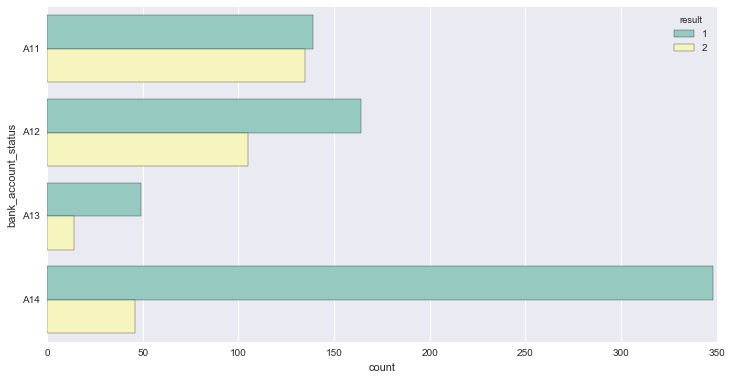

In [98]:
features = data.ix[:,:-1]
features = features.columns.tolist()
a0 = sns.countplot(y=features[0], hue="result", data=data,order=np.unique(data[features[0]].values), palette="Set3")

```Status of existing checking account 
A11 : ... < 0 DM
A12 : 0 <= ... < 200 DM 
A13 : ... >= 200 DM / salary assignments for at least 1 year 
A14 : no checking account```

Not having a checking account is a strong good signal

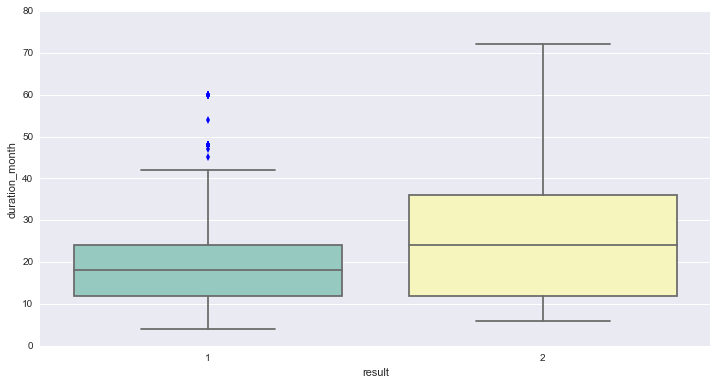

In [99]:
a1 = sns.boxplot(x="result", y="duration_month", data=data,palette="Set3")

The boxplot above shows the duration of the credit for our 2 classes of borrowers.

A very long credit (more than 50 months) is bad signal.

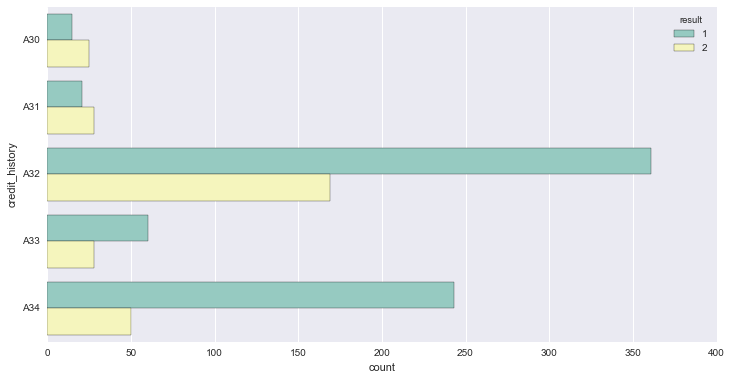

In [100]:
a2 = sns.countplot(y=features[2], hue="result", order=np.unique(data[features[2]].values), data=data, palette="Set3")

```Credit history 
A30 : no credits taken/ all credits paid back duly 
A31 : all credits at this bank paid back duly 
A32 : existing credits paid back duly till now 
A33 : delay in paying off in the past 
A34 : critical account/ other credits existing (not at this bank) ```

Havig a critical credit history is suprisingly a good signal.

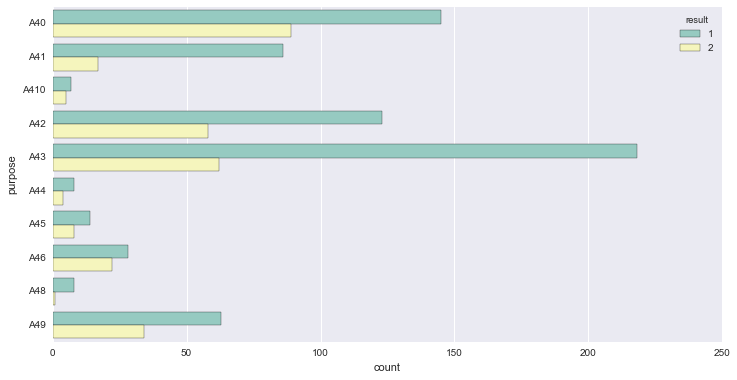

In [101]:
a3 = sns.countplot(y=features[3], hue="result", order=np.unique(data[features[3]].values), data=data, palette="Set3")

```
Purpose
A40 : car (new) 
A41 : car (used) 
A42 : furniture/equipment 
A43 : radio/television 
A44 : domestic appliances 
A45 : repairs 
A46 : education 
A47 : (vacation - does not exist?) 
A48 : retraining 
A49 : business 
A410 : others```

Asking a credit for a radio / television is a good signal

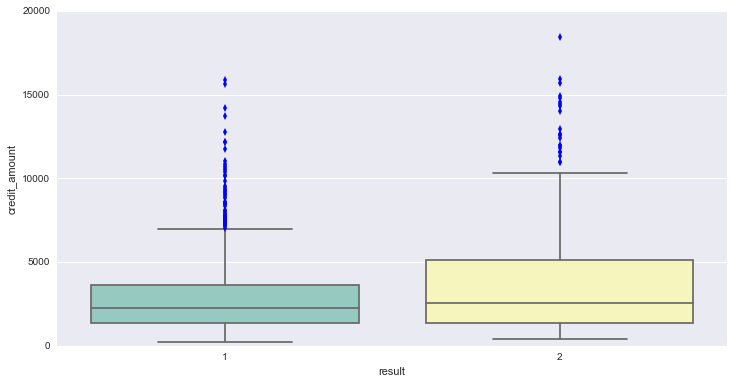

In [102]:
a1 = sns.boxplot(x="result", y="credit_amount", data=data,palette="Set3")

For both classes medians of the credit amount are similar.
It will be hard to derive meaninful information to classify our borrowers from this feature.

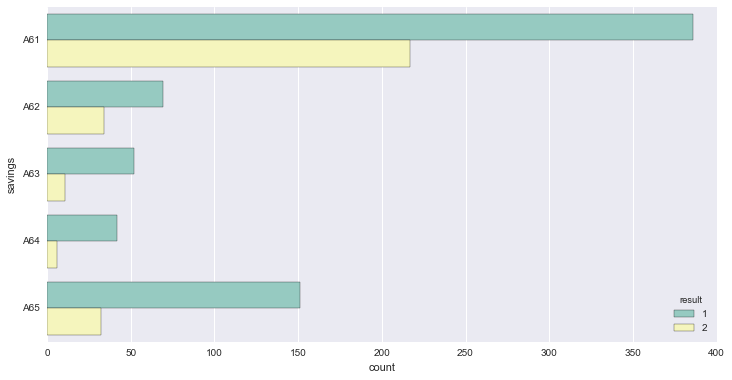

In [103]:
a5 = sns.countplot(y=features[5], hue="result", order=np.unique(data[features[5]].values), data=data, palette="Set3")

```
Savings account/bonds 
A61 : ... < 100 DM 
A62 : 100 <= ... < 500 DM 
A63 : 500 <= ... < 1000 DM 
A64 : .. >= 1000 DM 
A65 : unknown/ no savings account ````
Borrowers' savings do not appear to be very insightful.

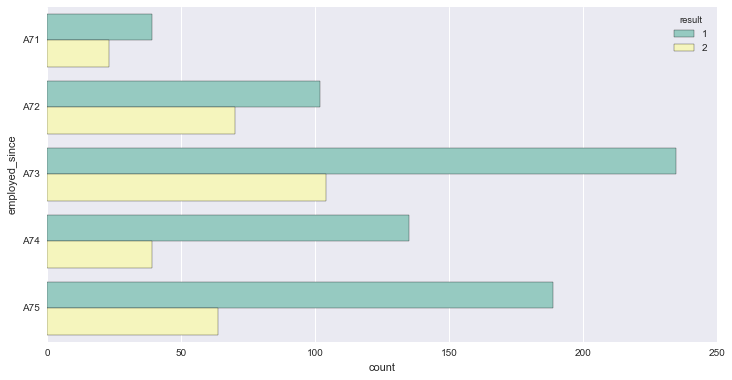

In [104]:
a6 = sns.countplot(y=features[6], hue="result", order=np.unique(data[features[6]].values), data=data, palette="Set3")

```
Present employment since 
A71 : unemployed 
A72 : ... < 1 year 
A73 : 1 <= ... < 4 years 
A74 : 4 <= ... < 7 years 
A75 : .. >= 7 years 
```
Borrowers who have been working for the same employer for a long time is a good signal.

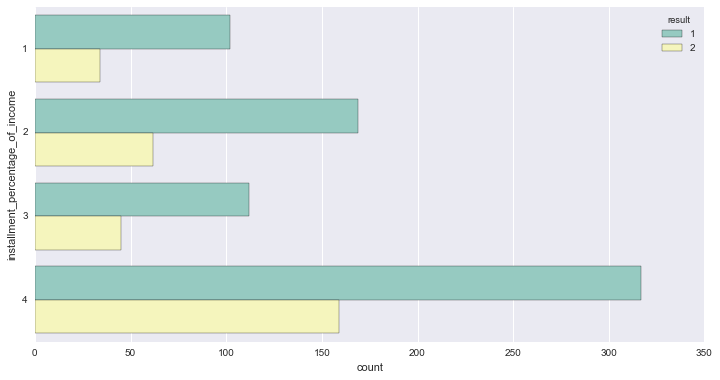

In [142]:
a7 = sns.countplot(y=features[7], hue="result", order=np.unique(data[features[7]].values), data=data, palette="Set3")

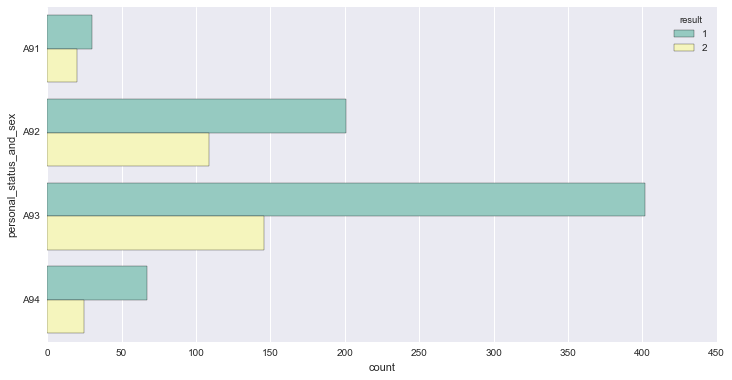

In [143]:
a8 = sns.countplot(y=features[8], hue="result", order=np.unique(data[features[8]].values), data=data, palette="Set3")

``` Personal status and sex 
A91 : male : divorced/separated 
A92 : female : divorced/separated/married 
A93 : male : single 
A94 : male : married/widowed 
A95 : female : single ```

Males are more likely to pay their debts than women.

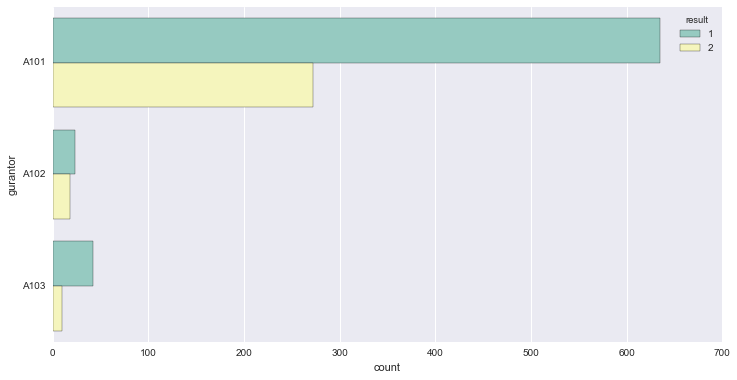

In [107]:
a9 = sns.countplot(y=features[9], hue="result", order=np.unique(data[features[9]].values), data=data, palette="Set3")

```Other debtors / guarantors 
A101 : none 
A102 : co-applicant 
A103 : guarantor ```

The wide majority does have guarantor nor debtor. This feature won't help much.

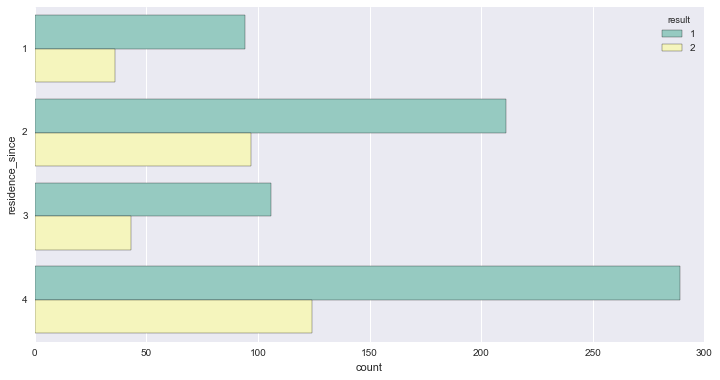

In [108]:
a10 = sns.countplot(y=features[10], hue="result", order=np.unique(data[features[10]].values), data=data, palette="Set3")

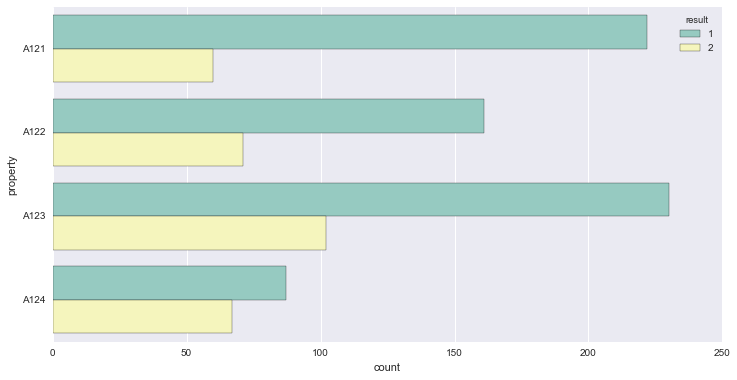

In [109]:
a11 = sns.countplot(y=features[11], hue="result", order=np.unique(data[features[11]].values), data=data, palette="Set3")

``` 
Property 
A121 : real estate 
A122 : if not A121 : building society savings agreement/ life insurance 
A123 : if not A121/A122 : car or other, not in attribute 6 
A124 : unknown / no property ```

The more real estate or properties you have, the more likely to pay back your loan you are.

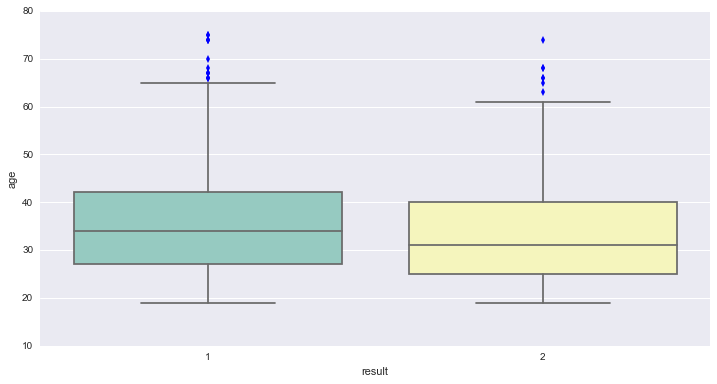

In [110]:
a12 = sns.boxplot(x="result", y="age", data=data,palette="Set3")

Our two classes are very similar when it comes to age.

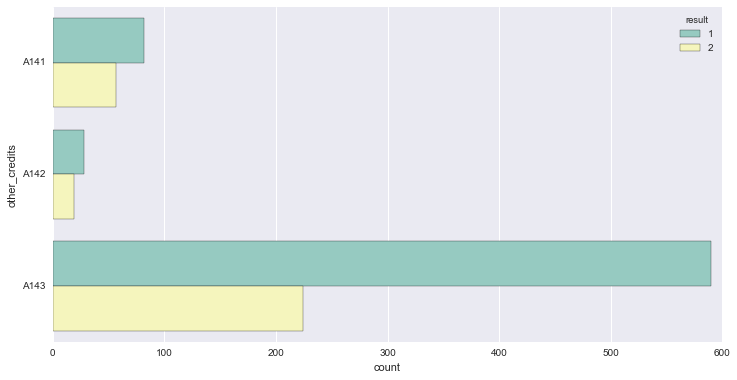

In [111]:
a13 = sns.countplot(y=features[13], hue="result", order=np.unique(data[features[13]].values), data=data, palette="Set3")

```
Other installment plans 
A141 : bank 
A142 : stores 
A143 : none```

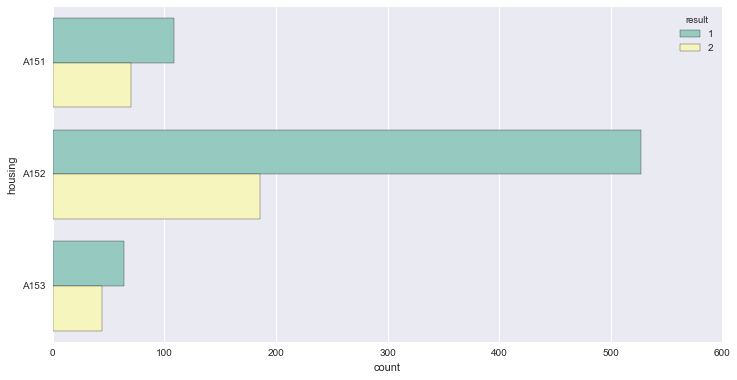

In [112]:
a14 = sns.countplot(y=features[14], hue="result", order=np.unique(data[features[14]].values), data=data, palette="Set3")

````
Housing 
A151 : rent 
A152 : own 
A153 : for free````

Again owning your home tends to be a positive signal.

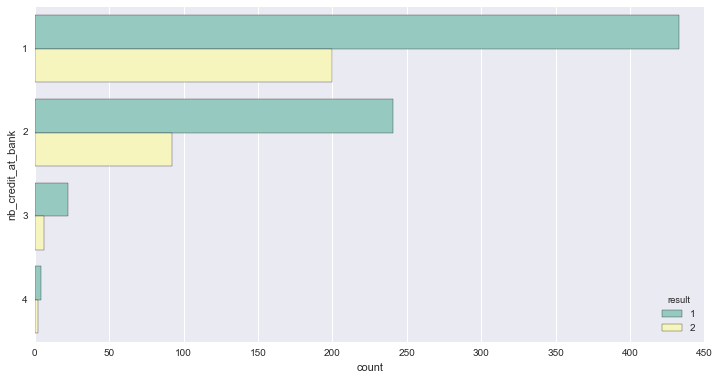

In [113]:
a15 = sns.countplot(y=features[15], hue="result", order=np.unique(data[features[15]].values), data=data, palette="Set3")

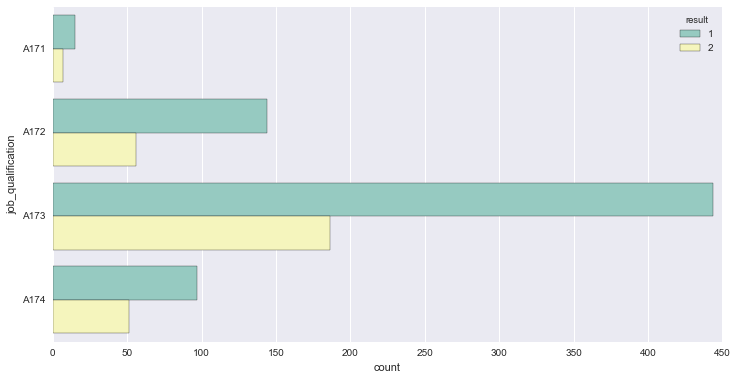

In [114]:
a16 = sns.countplot(y=features[16], hue="result", order=np.unique(data[features[16]].values), data=data, palette="Set3")

```
Job 
A171 : unemployed/ unskilled - non-resident 
A172 : unskilled - resident 
A173 : skilled employee / official 
A174 : management/ self-employed/ 
highly qualified employee/ officer ```

A higher the job qualification does not imply you are better borrower. This is not a strong signal though.

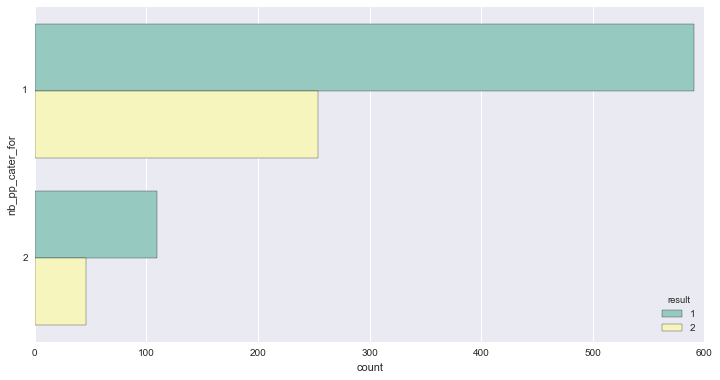

In [144]:
a17 = sns.countplot(y=features[17], hue="result", order=np.unique(data[features[17]].values), data=data, palette="Set3")

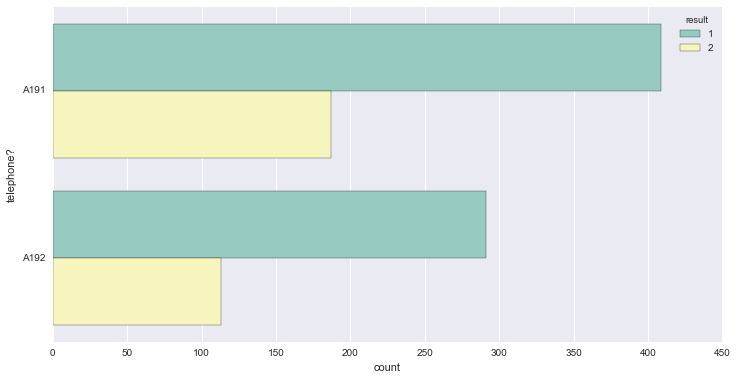

In [116]:
a18 = sns.countplot(y=features[18], hue="result", order=np.unique(data[features[18]].values), data=data, palette="Set3")

```
Telephone 
A191 : none 
A192 : yes, registered under the customers name 
```

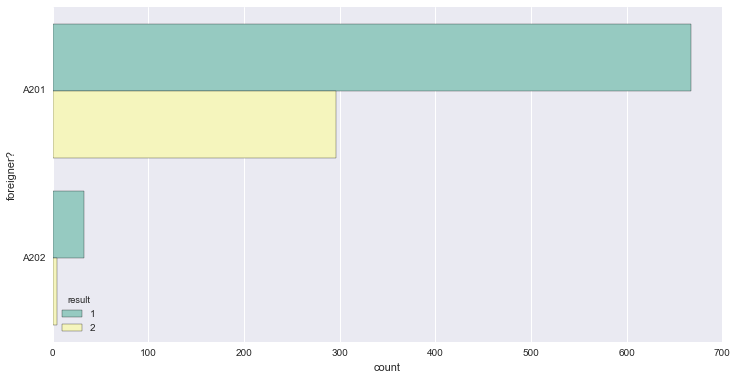

In [117]:
a19 = sns.countplot(y=features[19], hue="result", order=np.unique(data[features[19]].values), data=data, palette="Set3")

```
foreign worker 
A201 : yes 
A202 : no 
```

This bank seems to be specialized in granting credits to foreigners. Locals have less risk though!

Those are the most important findings we can derive from below:
- Borrowers with no checking account seem to be less risky
- If the credit history reflects a critical situation, borrower is surprisingly less risky
- People taking a credit for a radio/television are less risky
- People without a saving account are less risky
- People more than 4  (and 7 years) on a job are less risky

On the contrary, features like the age of the person don't seem to be related to the pay back ability of borrowers. It is interesting since we could test getting rid of those.

# Preprocessing

## Categorical or ordinal features

6 out of 20 features are ordinal.

For instance :
```
Present employment since 
A71 : unemployed 
A72 : ... < 1 year 
A73 : 1 <= ... < 4 years 
A74 : 4 <= ... < 7 years 
A75 : .. >= 7 years```

We will first treat them as categorical to find out the type of model that performs better our classification task. After that, we will try to see if converting those to ordinal helps to be more accurate.

In [118]:
X = data.ix[:,:-1]
y = data['result']

In [119]:
X.columns.tolist()

['bank_account_status',
 'duration_month',
 'credit_history',
 'purpose',
 'credit_amount',
 'savings',
 'employed_since',
 'installment_percentage_of_income',
 'personal_status_and_sex',
 'gurantor',
 'residence_since',
 'property',
 'age',
 'other_credits',
 'housing',
 'nb_credit_at_bank',
 'job_qualification',
 'nb_pp_cater_for',
 'telephone?',
 'foreigner?']

In [120]:
def preprocess(X,convert_numeric=False):
    outX = pd.DataFrame(index=X.index)
    target_cols = ['credit_history','employed_since','gurantor','property','other_credits','job_qualification']
    for col in X.columns:
        if convert_numeric == True and col in target_cols:
            distinct_val = sorted(X[col].unique())
            new_col = X[col].replace(distinct_val,range(0,len(distinct_val)))
        elif X[col].dtype == object:
            values = X[col].value_counts()
            nb_values = len(values)
            if nb_values == 2:
                new_col = X[col].replace([values.index[0],values.index[1]],[0,1])
            else:
                new_col = pd.get_dummies(X[col],prefix=col)
        else:
            new_col = X[col]

        outX = outX.join(new_col)
    return outX
    

In [121]:
X_all = preprocess(X) # with categorical features
X_all_num = preprocess(X,convert_numeric=True) # with ordinal features

# Correlation between variables

With our preprocessing done, we can look for correlations between the variables we identified above as being good candidates for separating borrowers

In [122]:
feature_index = [3,9,14,25,30,58]
corr_df = X_all.corr()
corr_df.iloc[feature_index,feature_index]

,bank_account_status_A14,credit_history_A34,purpose_A43,savings_A65,employed_since_A75,foreigner?
bank_account_status_A14,1.000000,0.168879,0.076027,0.142364,0.072110,-0.017108
credit_history_A34,0.168879,1.000000,-0.009983,0.013529,0.150968,0.036770
purpose_A43,0.076027,-0.009983,1.000000,0.004378,0.046928,-0.063242
savings_A65,0.142364,0.013529,0.004378,1.000000,0.105303,0.003138
employed_since_A75,0.072110,0.150968,0.046928,0.105303,1.000000,-0.053144
foreigner?,-0.017108,0.036770,-0.063242,0.003138,-0.053144,1.000000


There is little correlation between the above features (max is 0.17) but interestingly there are mostly positive values showing that there are going in the same direction.

Here method like PCA will probably not perform very well, on the contrary a Naive Bayes model is a good candidate.

# Models considered

### Naive Bayes
We only have 1000 data points to train our algorithm. Naive Bayes is known to perform well when we don’t have much data to train our model. That’s why it makes a good candidate. It also have the advantage of being fast when compared to more complicated models.
The disadvantage is that it assumes that features are independent from one another which does not make it a good candidate for cases when we most probably have highly correlated input variables (it is not the case here).


### Decision Trees
Decision trees require little data preparation (for instance, it copes with our unscaled vectors) and it is easy to understand. Our data is not too unbalanced (67% of one class, 33% of another) to be a serious problem to this technique.
On the other side, It is prone to overfitting if we don’t limit the size of the tree (minimum sample per node, per leaf, max depth of the tree). A tree leaves setting apart small number of instance is specialized in the training data and hence won’t generalize well.

For all models, we will tune our parameters on the train set thanks to cross-validation.

For the Naive Bayes approach, we will experiment on reducing the number features considered and see if we obtain better results on our cost function.

In [123]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import cross_validation
from sklearn import metrics
import time
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn import tree
import pydot
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB

Some convinience methods

In [124]:
def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

In [125]:
def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return cost(target.values, y_pred)

In [126]:
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "Cost estimation for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "Cost estimation for test set: {}".format(predict_labels(clf, X_test, y_test))

We split our data between a test and train set.

In [127]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y, test_size=0.2,random_state=15)

X_train_num, X_test_num, y_train_num, y_test_num = cross_validation.train_test_split(X_all_num, y, test_size=0.2,random_state=15)

Now let's benchmarch a Decision tree and a Naive Bayes model. According to the result, we will elaborate on one of them.

In [128]:
from sklearn.grid_search import GridSearchCV
parameters = {'max_depth': range(6,9,1),
             'min_samples_split': range(5,61,5),
             'max_features' : range(15,26,2)}
clf = DecisionTreeClassifier(random_state=15)

tree_model = GridSearchCV(clf,parameters, scoring=cost_estimate,cv=5)
tree_model.fit(X_train, y_train)
print tree_model.best_params_
print tree_model.best_score_

{'max_features': 25, 'min_samples_split': 30, 'max_depth': 6}
-0.9325


In [129]:
NB_alone = GaussianNB()
sizes = range(200,801,200)

for i,v in enumerate(sizes):
    train_predict(NB_alone,X_train[:v],y_train[:v],X_test,y_test)
    
for i,v in enumerate(sizes):
    train_predict(tree_model,X_train[:v],y_train[:v],X_test,y_test)


------------------------------------------
Training set size: 200
Training GaussianNB...
Done!
Training time (secs): 0.002
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.001
Cost estimation for training set: 0.56
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.001
Cost estimation for test set: 0.69
------------------------------------------
Training set size: 400
Training GaussianNB...
Done!
Training time (secs): 0.001
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.001
Cost estimation for training set: 0.6475
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.000
Cost estimation for test set: 0.67
------------------------------------------
Training set size: 600
Training GaussianNB...
Done!
Training time (secs): 0.003
Predicting labels using GaussianNB...
Done!
Prediction time (secs): 0.004
Cost estimation for training set: 0.688333333333
Predicting labels using GaussianNB...
Done!
Prediction time (s

Our Naive Bayes model performs consistently better than the Decision tree.

First let's have a look at the features considered as important by the Descision tree, and then we will to conbine both models!

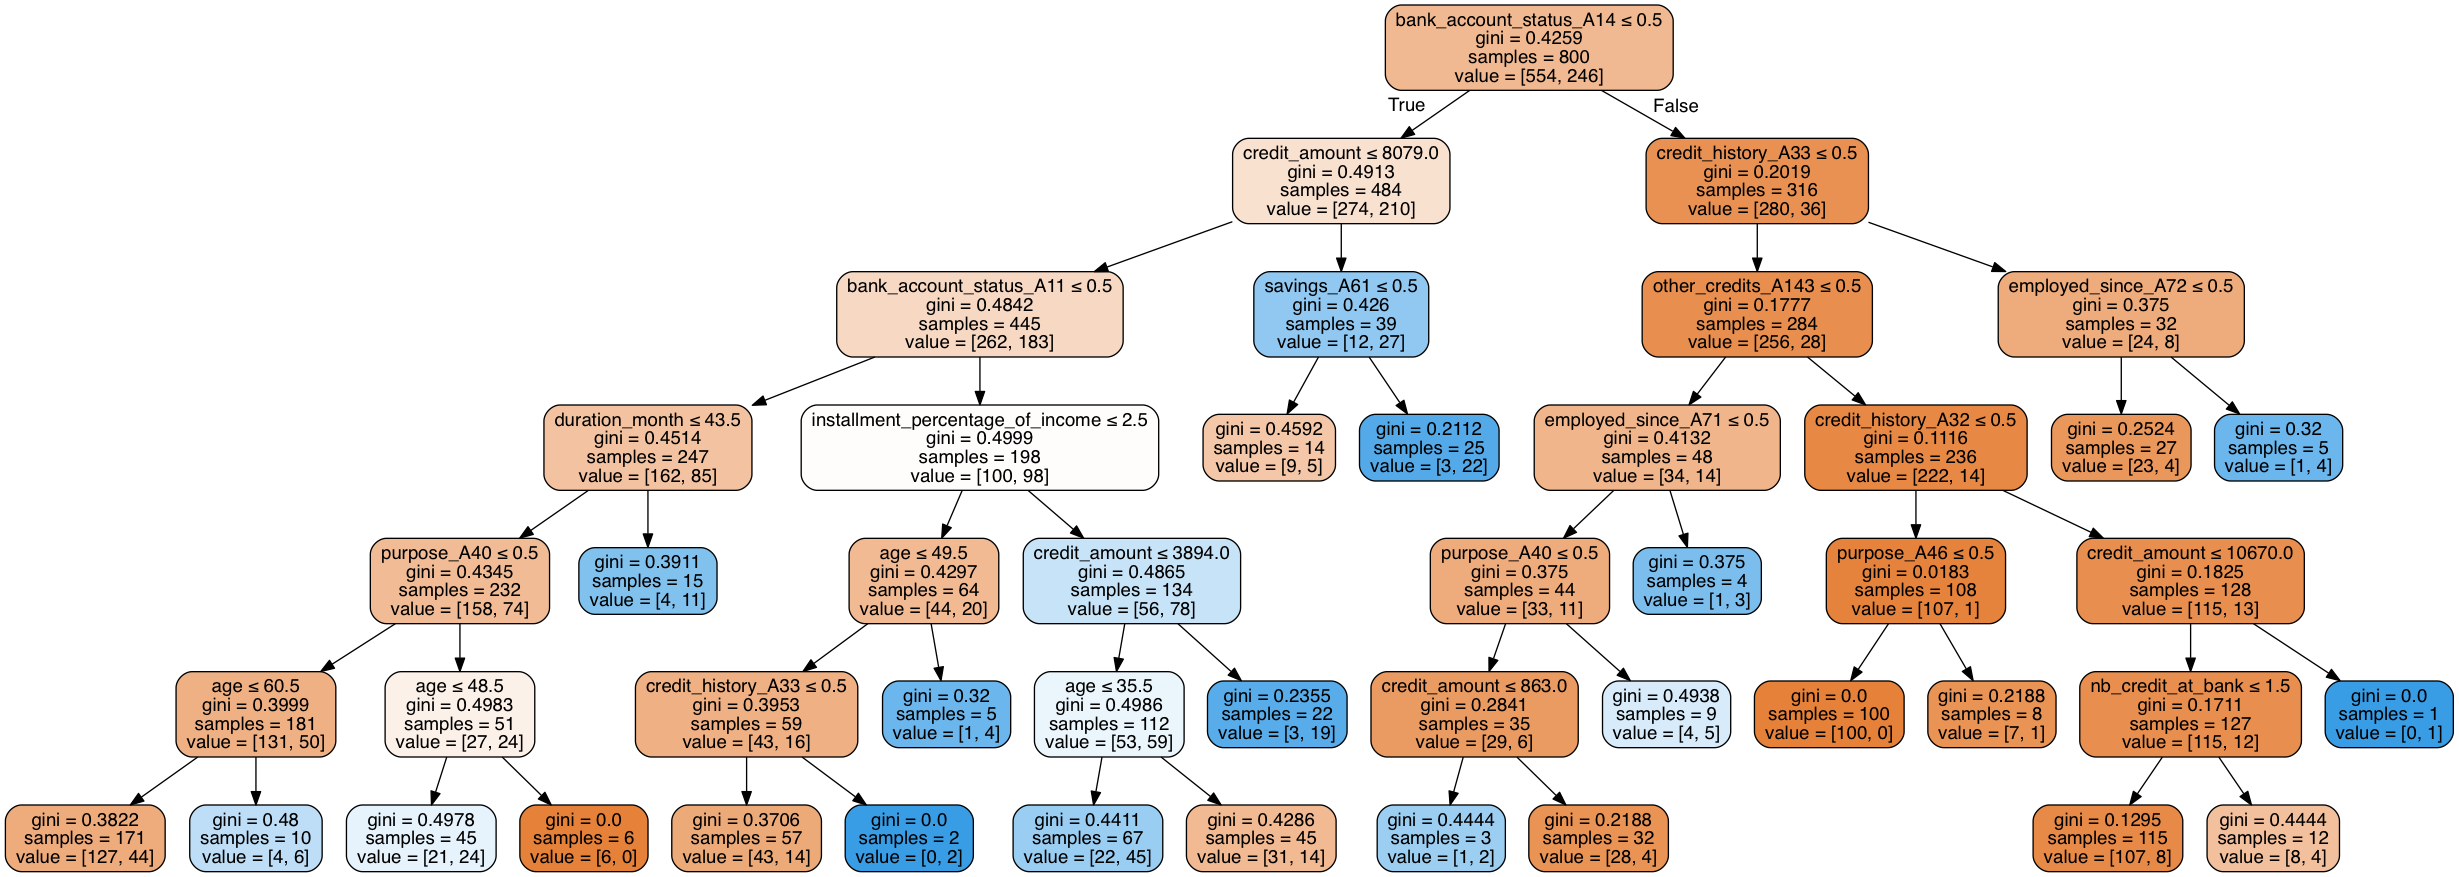

In [130]:
dot_data = StringIO()
tree.export_graphviz(tree_model.best_estimator_, out_file=dot_data,  
                         feature_names=X_all.columns.tolist(),  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


If we take the couple first criteria used by the tree we have :
- Bank account status A14 : we spotted it earlier
- Credit history A 33 : also shows differences between borrowers.
- Credit Amount < 8079 : The tree uses the outliers depicted in our boxplot

Now, let's experiment combining both models.

In [131]:
NB = GaussianNB()

x_tree = DecisionTreeClassifier(random_state=15)


estimators = Pipeline([
    ('sel',SelectFromModel(x_tree)),
    ('classifier',NB)
])

parameters = {
                'sel__estimator__max_depth':range(3,10,1),
                'sel__estimator__min_samples_split': range(15,30,2),
                'sel__estimator__max_features' : range(15,25,2),
                'sel__estimator__criterion' : ['gini','entropy'],
                'sel__estimator__max_leaf_nodes': range(50,90,5),
                'sel__threshold':['median','0.5*median','0.75*median','mean','1.25*median','1.5*median']
              }
nb_model = RandomizedSearchCV(estimators,parameters,scoring=cost_estimate,verbose=1,n_jobs=-1,n_iter=400,cv=5)
nb_model.fit(X_train,y_train)
scores = nb_model.grid_scores_
sorted(scores, key= lambda x: np.mean(x[2]),reverse=True )[:10]

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1112 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   17.3s finished


[mean: -0.74250, std: 0.04964, params: {'sel__estimator__min_samples_split': 29, 'sel__estimator__max_depth': 9, 'sel__estimator__criterion': 'gini', 'sel__estimator__max_features': 19, 'sel__estimator__max_leaf_nodes': 60, 'sel__threshold': '0.5*median'},
 mean: -0.74375, std: 0.09209, params: {'sel__estimator__min_samples_split': 19, 'sel__estimator__max_depth': 7, 'sel__estimator__criterion': 'gini', 'sel__estimator__max_features': 19, 'sel__estimator__max_leaf_nodes': 80, 'sel__threshold': '1.25*median'},
 mean: -0.74500, std: 0.04858, params: {'sel__estimator__min_samples_split': 23, 'sel__estimator__max_depth': 9, 'sel__estimator__criterion': 'gini', 'sel__estimator__max_features': 21, 'sel__estimator__max_leaf_nodes': 75, 'sel__threshold': '0.5*median'},
 mean: -0.74500, std: 0.04858, params: {'sel__estimator__min_samples_split': 23, 'sel__estimator__max_depth': 9, 'sel__estimator__criterion': 'gini', 'sel__estimator__max_features': 21, 'sel__estimator__max_leaf_nodes': 65, 'sel

In [132]:
NB_alone_predictions = NB_alone.predict(X_test) 
NB_predictions = nb_model.predict(X_test) 

print "Simple Naive Bayes"
print cost(y_test,NB_alone_predictions)

print "Naive Bayes combined with tree for feature selection"
print cost(y_test,NB_predictions)

Simple Naive Bayes
0.675
Naive Bayes combined with tree for feature selection
0.675


The model with feature selection performs slighly better but if we run the grid search several times, we sometimes get worse results on the test set.

In this situation, we favor the **simpler Naive Bayes model**.

# Changing the 0.5 probabilistic threshold

As shown below we manage to lower the cost by being a lot more conservative than the model and allowing the credit only when the model is very confident about its prediction.

In [133]:
def chooseThreshold(model,new_threshold):
    prediction = []
    probas = model.predict_proba(X_test)
    for proba in probas:
        if proba[0] > new_threshold:
            prediction.append(1)
        else:
            prediction.append(2)
    return prediction
    
    

Changing the threshold to 0.95 improves our cost by 12.59 %. Making it 0.59


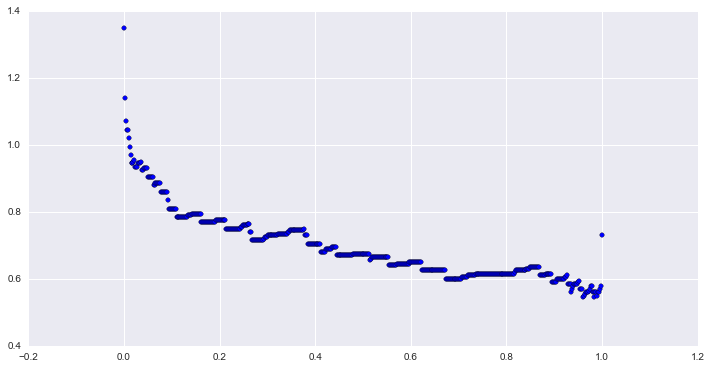

In [138]:
thresholds = np.linspace(0,1,500)

for t in thresholds:
    plt.scatter(t,cost(y_test,chooseThreshold(NB_alone,t)))

new_cost = cost(y_test,chooseThreshold(nb_model,0.95))
std_cost = float(0.675)
increase = (std_cost - new_cost) / std_cost
print 'Changing the threshold to {0} improves our cost by {1:.2f} %. Making it {2}'.format(0.95,increase *100,new_cost)

## Ordinal Values turned to numeric attributes

In [139]:
NB_num = GaussianNB()
NB_num.fit(X_train_num,y_train_num)

NB_num_predictions = NB_num.predict(X_test_num) 

print "Naive Bayes 2"
print cost(y_test_num,NB_num_predictions)

Naive Bayes 2
0.635


In [140]:
def chooseThreshold(model,new_threshold):
    prediction = []
    probas = model.predict_proba(X_test_num)
    for proba in probas:
        if proba[0] > new_threshold:
            prediction.append(1)
        else:
            prediction.append(2)
    return prediction
    
    

0.53


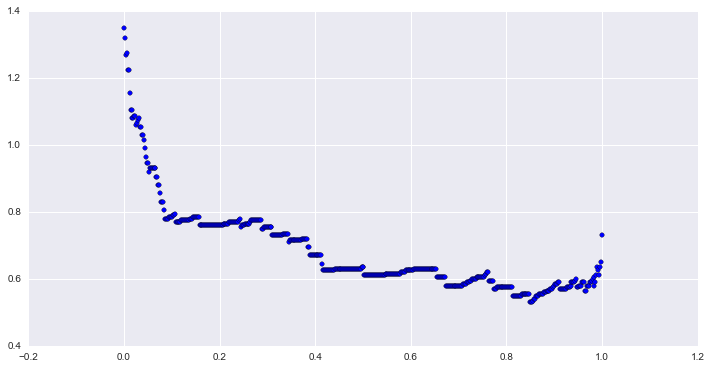

In [141]:
thresholds = np.linspace(0,1,500)

for t in thresholds:
    plt.scatter(t,cost(y_test_num,chooseThreshold(NB_num,t)))

print cost(y_test,chooseThreshold(NB_num,0.85))

Below we can have a look at the predictions that did match the test data against which we tested our model.

In [225]:
wrong_predictions = []

for i,v in enumerate(y_test):
    if v != chooseThreshold(NB_num,0.85)[i]:
        wrong_predictions.append(y_test.index[i])

wrong = data.iloc[wrong_predictions,:]

In [229]:
#wrong[wrong['result'] == 2]

In [228]:
#wrong[wrong['result'] == 1]

# Conclusion

In this Capstone project we manage to develop a model allowing a bank to profitably screen borrowers' applications.

Our final model performed 0.53 versus 0.7 which was the target we wanted to beat in order for a finantial institution to earn money.

Along the way, we discovered that using ordinal values on a set of 6 features out of 20 helped us improve our model. Before running our Naive Bayes model we tried to reduce the number of features keeping only the features considered as important for a Decision Tree but the results were not sufficiantly significant to justify for the increased complexity.

As it is costly to have borrowers defaulting, we also decided to change the treshold of the model so that it predicts that someone should be accepted when it more certain about this decision.